First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.

## Example dataset

https://www.kaggle.com/competitions/rossmann-store-sales/data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
pathname = 'data/rossmann/train.csv'

### Data Import

The columns are enclosed in double quotes so the read_csv cribbed about types, so I've explicitly set dtypes for these 2 columns

In [6]:
df = pd.read_csv(pathname, dtype={'Promo': str, 'StateHoliday' : str})

In [7]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  object
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 69.8+ MB


In [9]:
df.Date = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [10]:
df.set_index('Date', inplace=True)

In [11]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [12]:
# Select a random 'Store'
#random_store = df['Store'].sample(n=1).values[0]  # Get a random store name
random_store = 962

# Filter the DataFrame for the selected random store
store_data = df[df['Store'] == random_store]

In [13]:
store_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,962,5,9370,1119,1,1,0,1
2015-07-30,962,4,7332,858,1,1,0,1
2015-07-29,962,3,6185,767,1,1,0,1
2015-07-28,962,2,8034,960,1,1,0,1
2015-07-27,962,1,9092,1015,1,1,0,1


In [14]:
features = ['Date', 'Sales']

In [15]:
# Assuming store_data is already defined as per the previous code

# Filter rows where Sales = 0 and Open = 1
sales_when_open = store_data[(store_data['Open'] == 1)]

In [16]:
X = sales_when_open[['Sales']]
X.head()

,Sales
Date,
2015-07-31,9370
2015-07-30,7332
2015-07-29,6185
2015-07-28,8034
2015-07-27,9092


In [17]:
X.tail()

,Sales
Date,
2013-01-07,10959
2013-01-05,5110
2013-01-04,5293
2013-01-03,5019
2013-01-02,4972


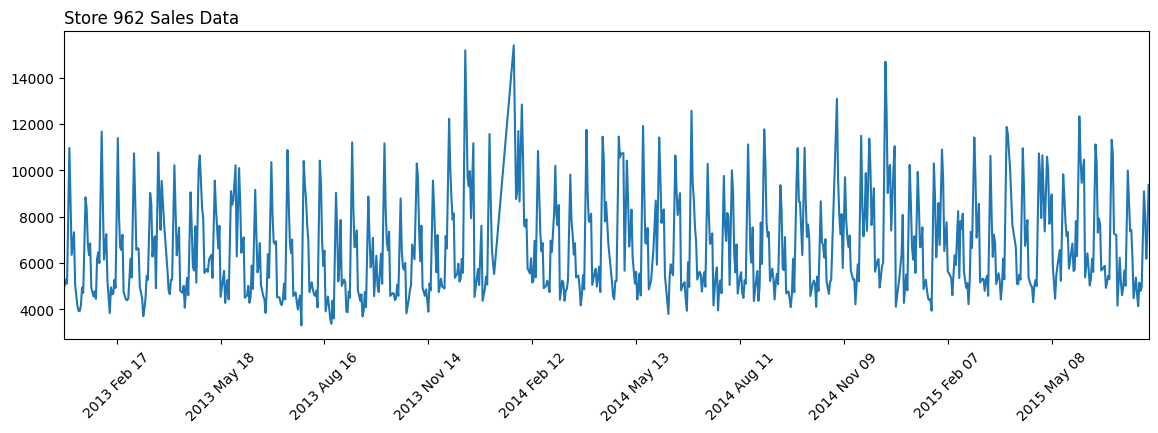

In [18]:
import matplotlib.dates as mdates

plt.figure(figsize=(14,4))
plt.plot(X.index, X.Sales)
plt.title(f'Store {random_store} Sales Data', loc = 'left')

# Format the x-axis to show month labels every 30 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90))  # Set major ticks every 30 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b %d'))  # Format ticks to show month and day

# Set x-axis limits to start at the minimum index
plt.xlim(X.index.min(), X.index.max())

#Rotate the x-axis labels for better visibility
plt.xticks(rotation=45);
plt.savefig('images/rossmann_training_data.png')
#plt.grid();

In [19]:
# Resample the data to weekly frequency and sum the values
weekly_totals = X.resample('W').sum()

In [20]:
#Step 1 
train_size = int(len(weekly_totals) * 0.8)
train, test = weekly_totals[:train_size], weekly_totals[train_size:]

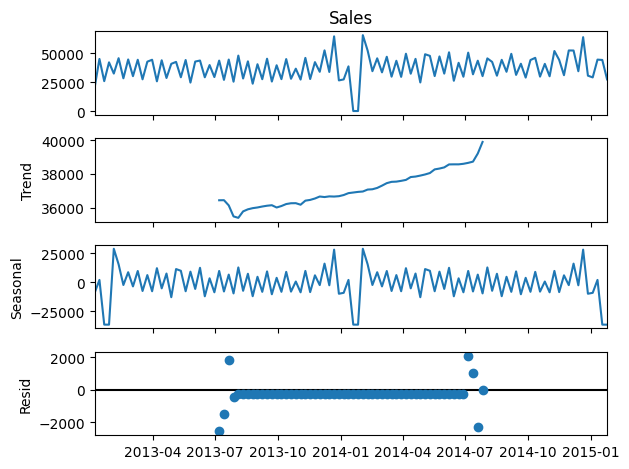

In [21]:
# Step 2: Decompose the time series
decomposition = seasonal_decompose(train['Sales'], model='additive', period = 52)
decomposition.plot()

plt.show()

## Plotting ACF and PACF

To find the right $p \& q$ we plot the acf functions

<font color="red">Not sure which one to plot for getting the p & q - whether to use training data as-s or the residuals after decomposition!</font>

In this case however, we find that $p \& q$ turn out to be the same in both cases. 

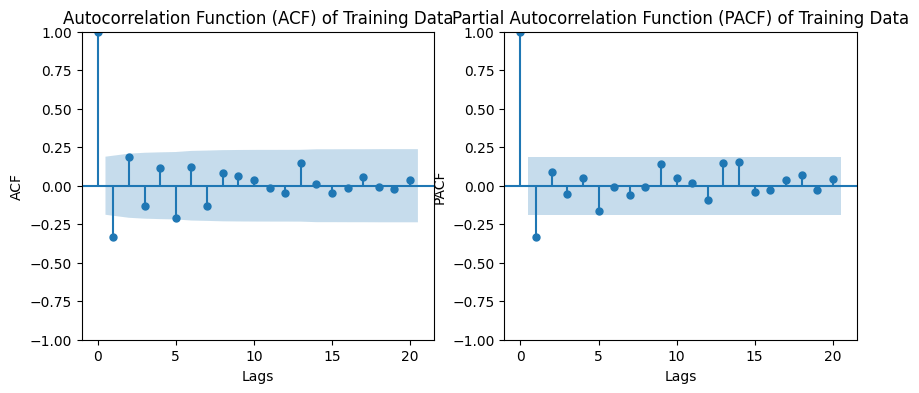

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
plot_acf(train['Sales'], lags=20, ax=ax[0]); 
ax[0].set_title('Autocorrelation Function (ACF) of Training Data')
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('ACF')
plot_pacf(train['Sales'], lags=20, ax=ax[1]); 
ax[1].set_title('Partial Autocorrelation Function (PACF) of Training Data')
ax[1].set_xlabel('Lags')
ax[1].set_ylabel('PACF')
#plt.savefig('images/rossmann_sales_training_ACF.png')
plt.show()

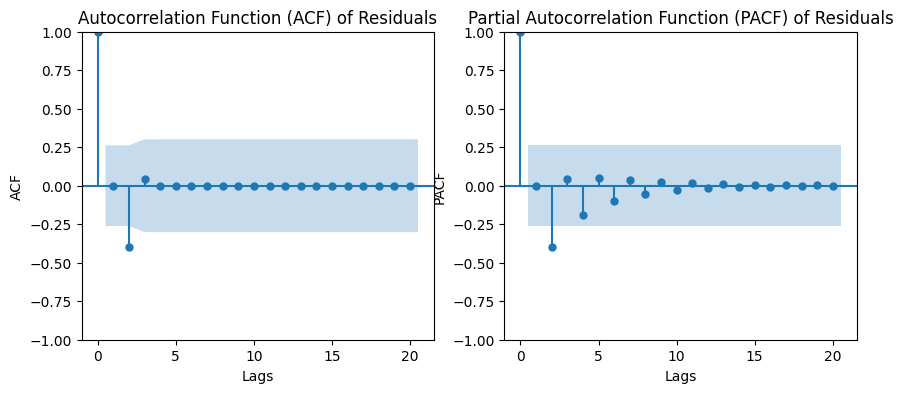

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
plot_acf(decomposition.resid.dropna(), lags=20, ax=ax[0]); 
ax[0].set_title('Autocorrelation Function (ACF) of Residuals')
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('ACF')
plot_pacf(decomposition.resid.dropna(), lags=20, ax=ax[1]); 
ax[1].set_title('Partial Autocorrelation Function (PACF) of Residuals')
ax[1].set_xlabel('Lags')
ax[1].set_ylabel('PACF')
plt.savefig('images/rossmann_sales_residuals_ACF.png')
plt.show()

In [25]:
# Step 3: Build the SARIMAX model
model = SARIMAX(train['Sales'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 52))
results = model.fit()

# Step 4: Forecast the test set
forecast = results.get_forecast(steps=len(test))
predicted_mean = forecast.predicted_mean
predicted_ci = forecast.conf_int()

# Step 5: Assess accuracy
mae = mean_absolute_error(test['Sales'], predicted_mean)
rmse = np.sqrt(mean_squared_error(test['Sales'], predicted_mean))

print(f'MAE: {mae}, RMSE: {rmse}')

C:\Users\jaide\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\jaide\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 3853.882397599477, RMSE: 5567.602464435938


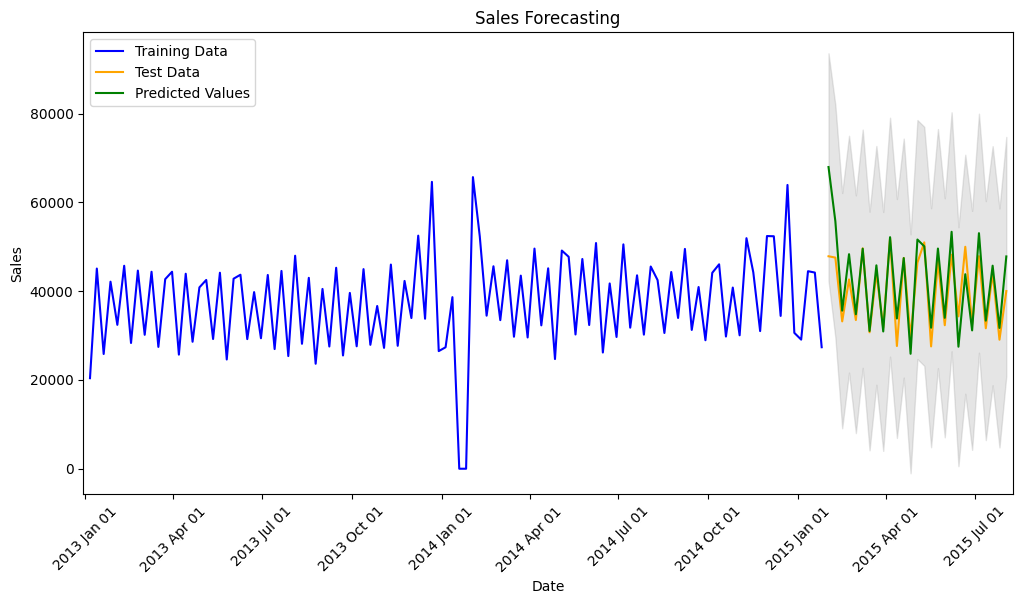

In [26]:
# Step 6: Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(train['Sales'], label='Training Data', color='blue')
plt.plot(test['Sales'], label='Test Data', color='orange')
plt.plot(predicted_mean, label='Predicted Values', color='green')
plt.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='gray', alpha=0.2)

# Format the x-axis to show month labels every 30 days
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator()-1)  # Set major ticks every 30 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b %d'))  # Format ticks to show year and month

# Set x-axis limits to start at the minimum index
plt.xlim(train.index.min() - (1 * train.index.freq), test.index.max() + (1 * train.index.freq) )

plt.title('Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45);
plt.legend(loc='upper left')
#plt.tight_layout()
plt.savefig('images/rossmann_sales_prediction.png')
plt.show()